# Studium przypadku - Analiza danych dotyczących udaru mózgu

Autor: Dariusz Max Adamski

Źródło: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

---

# Wymagania

Studium ma mieć postać raportu (pdf) z wynikami (wartości, tabele, wykresy...) i wnioskami z nich płynącymi. Zakres analizy musi być oryginalny, tzn. nie może pokrywać się z innymi pracami znanymi autorowi dotyczącymi wybranego zbioru. Nie trzeba zamieszczać w raporcie fragmentów kodu, ale trzeba dokładnie napisać jakich narzędzi/pakietów/źródeł używano, i oczywiście szczegółowo jakich algorytmów i parametrów.

Co najmniej trzy algorytmy uczenia maszynowego na osobę. Jeśli więcej niż jedna osoba analizuje ten sam zbiór danych, każda osoba niezależnie i samodzielnie wykorzystuje co najmniej trzy metody analizy – inne, niż wybrały pozostałe osoby.

Szczegółowy opis wybranego zbioru danych i jego charakterystyki; przykłady przypadków ze zbioru danych i interpretacja atrybutów. Cel: wykrycie w zbiorze danych wszystkich ciekawych zależności i własności. W tym celu samodzielny wybór technik wedle nabytej wiedzy dotyczącej uczenia maszynowego. Interpretacja (na ile jest możliwa) wyindukowanej przez algorytmy wiedzy.

# Opis narzędzi

- `pandas` do obsługi tabel
- `numpy` do obsługi wektorów/macierzy
- `matplotlib` i `seaborn` do wizualizacji
- `sklearn` do algorytmów ML
- `imblearn` do niektórych miar i SMOTE

# Opis zbioru danych

Udary mózgu są drugą najczęstszą przyczyną śmierci - są odpowiedzialne za 11% zgonów globalnie [[1]][stroke-worldwide]. Jest zatem zapotrzebowanie na umożliwienie lub usprawnienie wczesnej diagnostyki.

Celem zbioru danych "stroke prediction dataset" jest predykcja binarnego atrybutu decyzyjnego "stroke", czyli określenie czy osoba o danych wartościach atrybutów dozna udaru mózgu.

Oryginalne źródło danych jest anonimowe (nie wiadomo czy badanie kliniczne, czy inne źródło). 

Zbiór zawiera 5110 obserwacji. Nie licząc unikalnego identyfikatora i atrybutu decyzyjnego, zbiór zawiera 10 atrybutów:

- "gender" - płeć pacjenta - cecha nominalna: Male / Female / Other
- "age" - wiek pacjenta - cecha ilościowa proporcjonalna
    - w tym zbiorze dzieci wiek dzieci do dwóch lat ma większą precyzję niż rok (zachowuje część ułamkową)
    - powyżej dwóch lat mierzone są ukończone lata 
- "hypertension" - czy pacjent ma nadciśnienie tętnicze - cecha binarna
- "heart_disease" - czy pacjent ma chorobę serca (nie określono jaką) - cecha binarna
- "ever_married" - czy pacjent miał kiedyś ślub - cecha binarna
- "work_type" - typ zatrudnienia - cecha nominalna: children / Govt_job / Never_worked / Private / Self-employed
    - "children" - oznacza, że pacjent jest dzieckiem, a nie że pracował z dziećmi (opiekun/nauczyciel/...)
    - "Govt_job" - urzędnik
    - "Never_worked" - nigdy nie pracował
    - "Private" - zatrudnienie w prywatnej firmie
    - "Self-employed" - samozatrudnienie
- "residence_type" - miejsce zamieszkania pacjenta - cecha nominalna: Urban / Rural
    - "Urban" - miejskie
    - "Rural" - wiejskie
- "avg_glucose_level" - średni pomiar poziomu glukozy (mg/dL) - cecha ilościowa proporcjonalna
- "bmi" - body-mass index pacjenta - cecha ilościowa interwałowa
- "smoking_status" - informacja o paleniu - cecha nominalna: never smoked / formerly smoked / smokes / unknown
    - "never smoked" - osoba nigdy nie paliła (nie wskazano czego; prawdopodobnie tytoniu)
    - "formerly smoked" - osoba paliła w przeszłości
    - "smokes" - osoba paląca
    - "Unknown" - brak danych
    
[stroke-worldwide]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5388903/

# Wstępna analiza zbioru

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', figsize=(10, 6))

### Wstępne przetworzenie zbioru 

Usuwamy identyfikatory pacjentów. Atrybuty binarne mapujemy na typ boolowski.

In [2]:
df = pd.read_csv('stroke.csv').drop(columns=['id'])
df.heart_disease = df.heart_disease.map(bool)
df.hypertension = df.hypertension.map(bool)
df.stroke = df.stroke.map(bool)
df.ever_married = df.ever_married.map(dict(Yes=True, No=False).__getitem__)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,False,True,True,Private,Urban,228.69,36.6,formerly smoked,True
1,Female,61.0,False,False,True,Self-employed,Rural,202.21,NaN,never smoked,True
2,Male,80.0,False,True,True,Private,Rural,105.92,32.5,never smoked,True
3,Female,49.0,False,False,True,Private,Urban,171.23,34.4,smokes,True
4,Female,79.0,True,False,True,Self-employed,Rural,174.12,24.0,never smoked,True
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,True,False,True,Private,Urban,83.75,NaN,never smoked,False
5106,Female,81.0,False,False,True,Self-employed,Urban,125.20,40.0,never smoked,False
5107,Female,35.0,False,False,True,Self-employed,Rural,82.99,30.6,never smoked,False
5108,Male,51.0,False,False,True,Private,Rural,166.29,25.6,formerly smoked,False


### Opis przykładowej obserwacji

Pierwsza obserwacja w zbiorze: meżczyzna, 67 lat, nie ma nadciśnienia tętniczego, ale ma chorobę serca. Miał ślub, mieszka w mieście i pracuje w prywatnej firmie. BMI wynoszące 36.6 wskazuje na otyłość. Średni poziom glukozy wynosił 228.69 mg/dL, co wskazuje na cukrzycę. W przeszłości palił. **Doznał udaru mózgu**.

Ostatnia obserwacja w zbiorze: kobieta, 44 lata, bez nadciśnienia i chorób serca. Miała ślub, mieszka w mieście, ma posadę urzędniczą. BMI 26.2 wskazuje na lekką nadwagę. Poziom glukozy 85.28 w normie. Nie ma informacji o paleniu. **Nie doznała udaru mózgu**.

### Dyskretyzacja niektórych atrybutów

Do wstępnej analizy danych *dodatkowo* zdyskretyzowaliśmy atrybuty `bmi` i `avg_glucose_level` (nie usunęliśmy oryginalnych atrybutów ze zbioru). Pierwszy według wytycznych WHO zwizualizowanych na poniższym wykresie, a drugi według poniższej tabeli, zakładając, że średni pomiar glukozy będzie zbliżony do standardowego pomiaru 2-3 godziny po jedzeniu.

Kategoria BMI będzie zapisana jako atrybut "bmi_range". Kategoria poziomu glukozy będzie zapisana jako atrybut "glucose_range". 

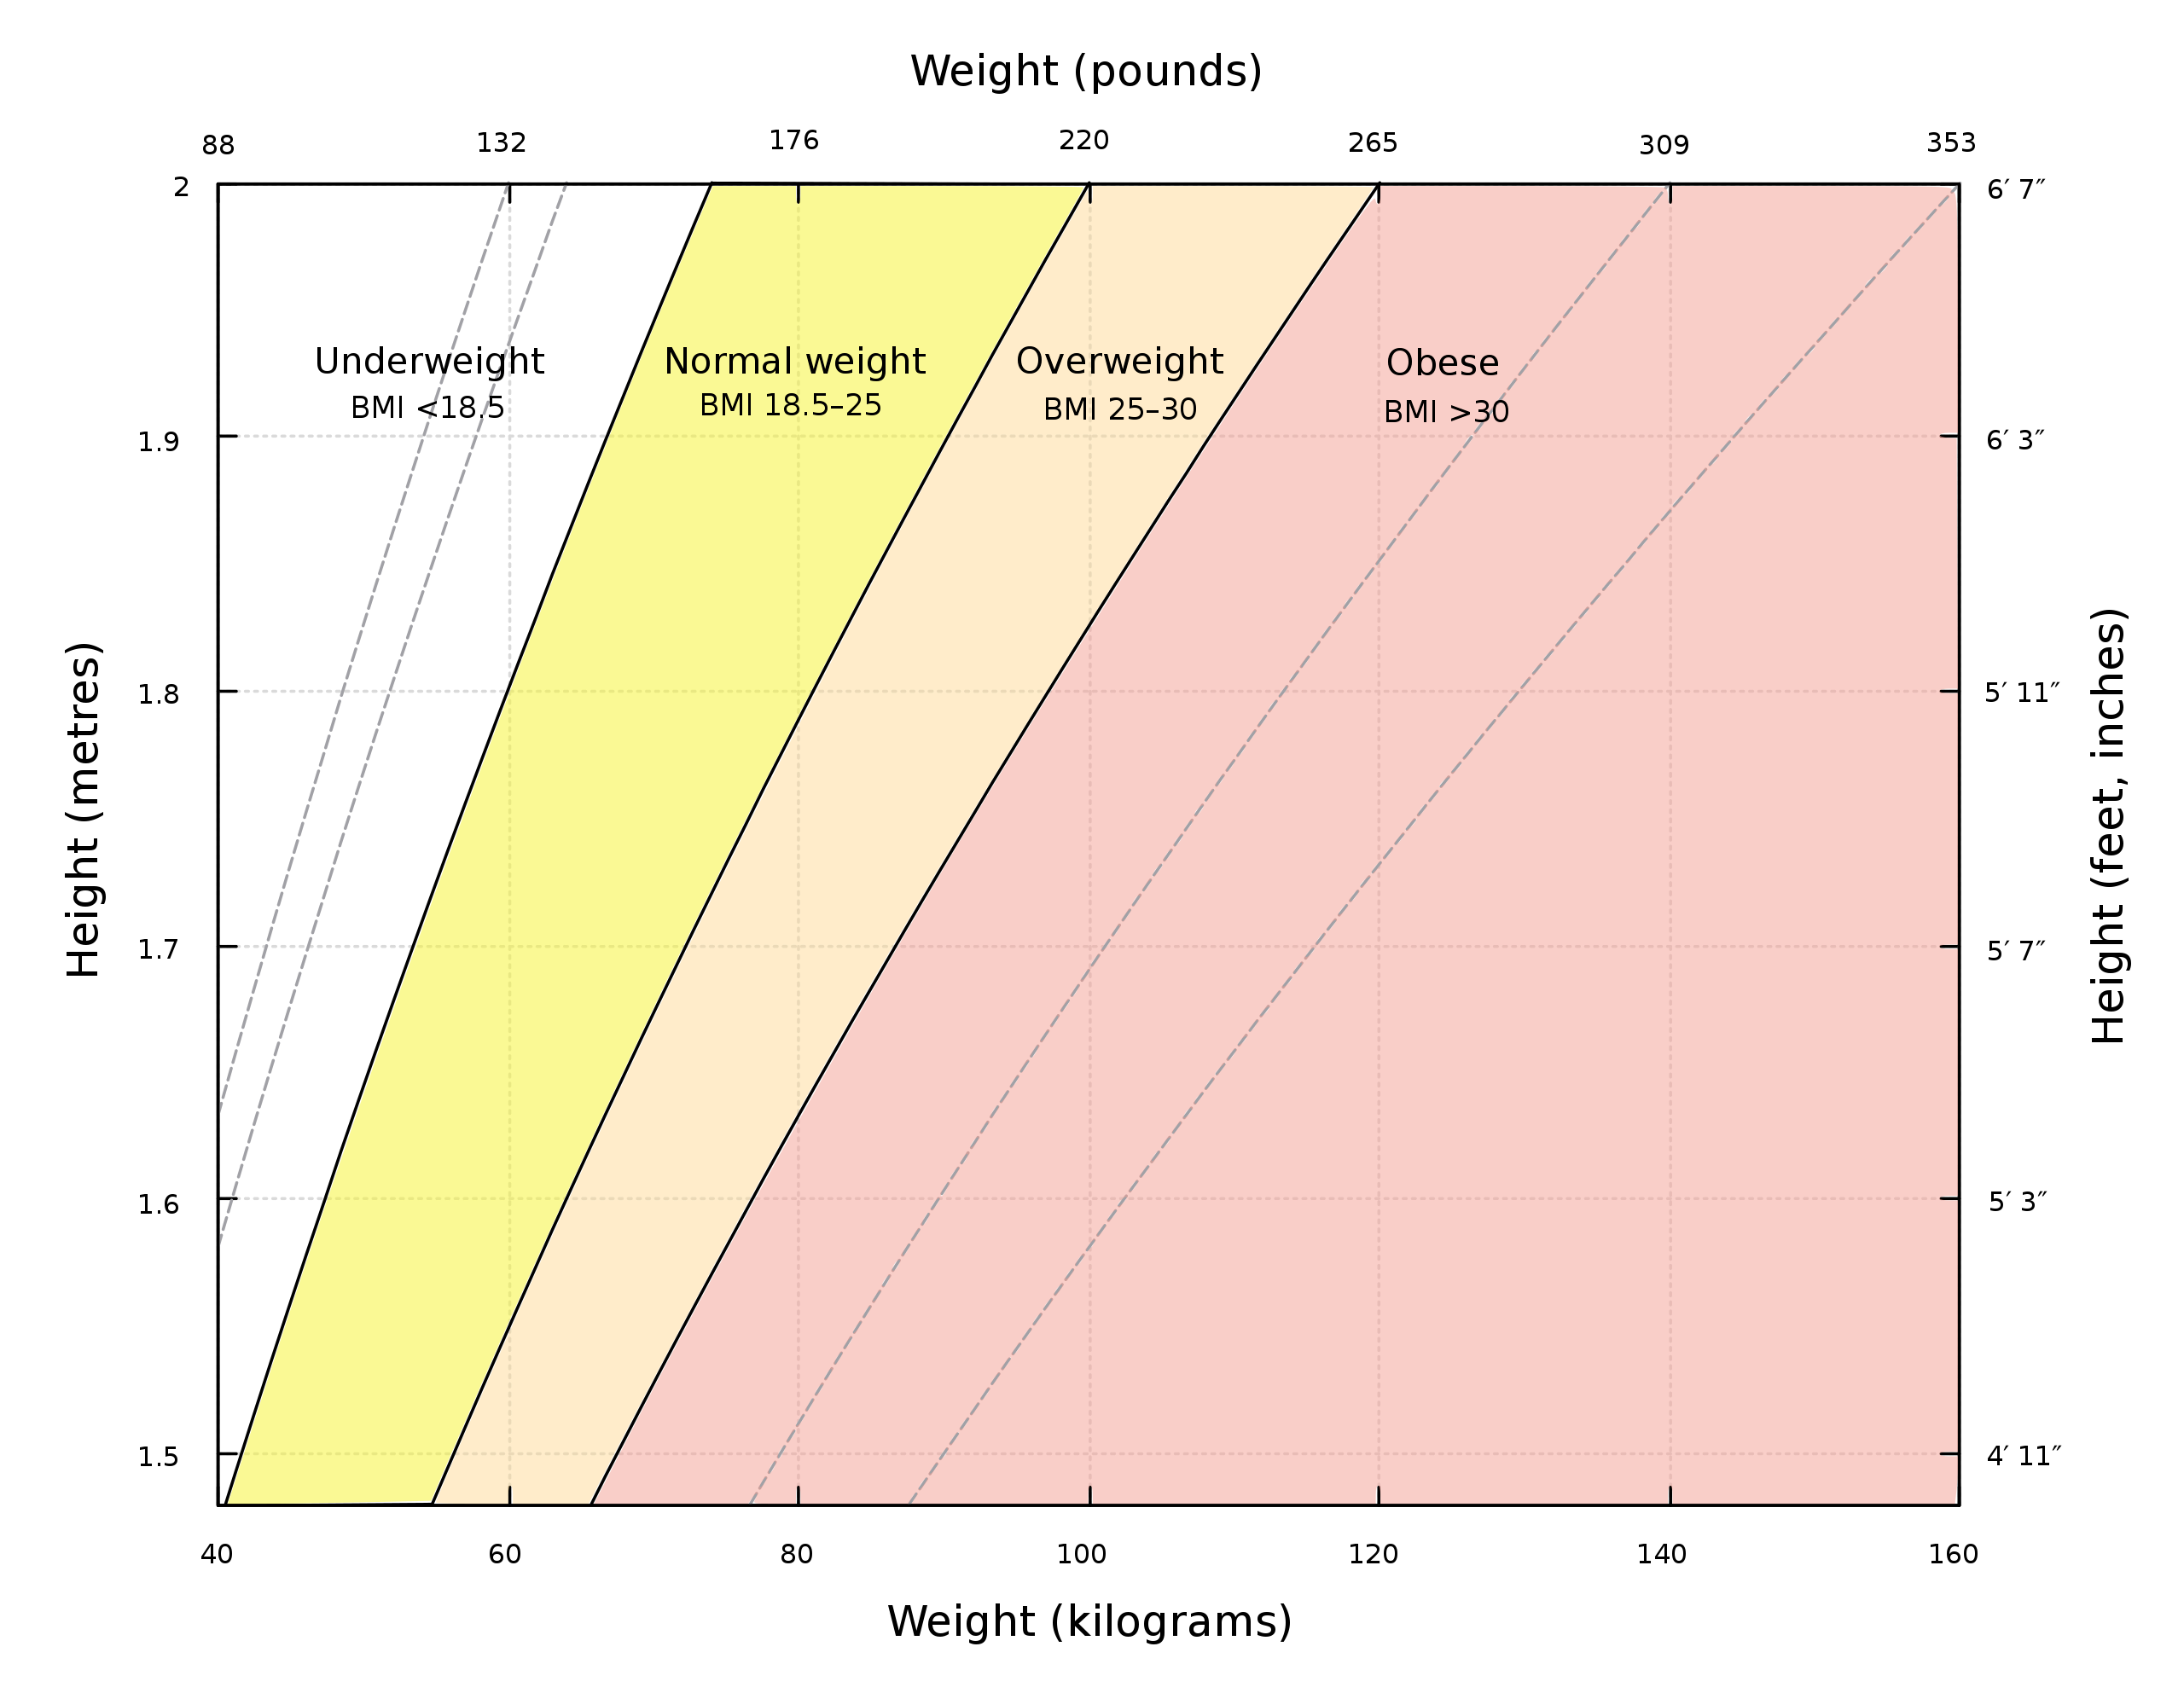

BMI chart, intended as an improvement for the one currently on the English wikipedia page. Curved lines show the principal cutoffs between the various BMI categories, as specified by the WHO

Source: https://commons.wikimedia.org/wiki/File:BMI_chart.svg

In [3]:
bmi_ranges = [
    (18.5, 'underweight'),
    (25.0, 'normal weight'),
    (30.0, 'overweight'),
    (None, 'obese'),
]

def bucketize(buckets):
    def do(x):
        for value, label in buckets[:-1]:
            if x < value: return label
        return buckets[-1][1]
    return do

df['bmi_range'] = df.bmi.map(bucketize(bmi_ranges))

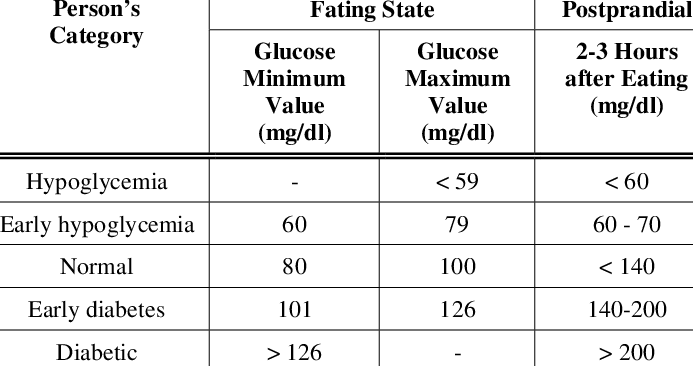

Source: Hariri, Ali & Wang, Le. (2011). Observer-Based State Feedback for Enhanced Insulin Control of Type ‘I’ Diabetic Patients. The open biomedical engineering journal. 5. 98-109. 10.2174/1874120701105010098. 

In [4]:
blood_sugar_levels = [
    (60, 'hypoglycemia'),
    (70, 'early hypoglycemia'),
    (140, 'normal'),
    (200, 'early diabetes'),
    (None, 'diabetes'),
]
    
df['glucose_range'] = df.avg_glucose_level.map(bucketize(blood_sugar_levels))

### Obsługa brakujących wartości

- Atrybut "bmi" ma 201 brakujących wartości (3.9% obserwacji).
    - Dla algorytmów, które nie akceptują brakujących wartości przyjmiemy medianę i dodamy dodatkowy binarny atrybut "bmi_unknown".
- Atrybut "gender" w 1 (jednym) przypadku przyjmuje wartość "Other".
    - Usuwamy 1 obserwację ponieważ na pewno nie jest reprezentatywna dla osób o oddmiennych cechach płci. Nie chcemy, żeby jakiś słaby algorytm nauczył się, że osoby o "gender" "Other" na 100% nie doznają udaru. Zmiana wartości atrybutu na jeden z innych też jest według mnie nieuzasadniona - nic na tym nie zyskamy.
- Atrybut "smoking_status" przyjmuje wartość "Unknown" w 1544 przypadkach (30% obserwacji)
    - Nic nie robimy i zostawiamy "Unknown" jako normalny wariant nominalnego "smoking_status"

In [5]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
bmi_range              0
glucose_range          0
dtype: int64

In [6]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [7]:
df[df.gender == 'Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_range,glucose_range
3116,Other,26.0,False,False,False,Private,Rural,143.33,22.4,formerly smoked,False,normal weight,early diabetes


In [8]:
df.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [9]:
df['bmi_unknown'] = df.bmi.isna()

### Atrybuty nominalne i binarne

Poniżej zamieszczamy tabelę z liczbą wystąpień każdej wartości w każdym z nominalnych i binarnych atrybutów. Dodatkowo obliczony jest procent obserwacji w którym ta wartość występuje. Dane z tabeli są też zwizualizowane na wykresach słupkowych.

**Wnioski**

- Dane są bardzo niezbalansowane. Tylko 4.87% doznało udaru
- Wśród pacjentów jest 17.2% więcej kobiet
- Tylko 9.75% pacjentów ma nadciśnienie tętnicze
- Tylko 5.40% pacjentów ma chorobę serca
- Większość pacjentów miało ślub 65.63%
- Zdecydowana większość pacjentów pracuje w prywatnej firmie (57.23%)
- Reszta pacjentów mniej więcej po równo pracuje w budżetówce, jest samozatrudniona, lub jest dziećmi
- Tylko 22 pacjentów (0.43%) nigdy nie pracowało
    - Tabelka z obserwacjami pod wykresami słupkowymi
    - Są to nastolatkowie do młodych dorosłych (od 13 do 23 roku życia)
    - Nikt z nich nie doznał udaru
- 37% pacjentów nigdy nie paliło, 30% nie wiadomo, reszta mniej więcej po równo pali lub paliła
- Byłem zaskoczony, że większość pacjentów ma bardzo wysokie BMI - pacjenci z otyłością (41.51%) i nadwagą (27.58%) to łącznie 69.09% wszystkich pacjentów. Źródło danych jest anonimowe, ale podejrzewam, że mogą nie pochodzić ze randomizowanego badania klinicznego, więc możemy mieć tu ukierunkowanie przez selekcję (selection-bias).
- Zdecydowana większość pacjentów ma normalny poziom glukozy (69.19%). Reszta rozkłada się mniej więcej po równo pomiędzy cukrzycą, wczesną cukrzycą, wczesną hipoglikemią i hipoglikemią (najmniej)

In [10]:
total_count = len(df)
categorical = 'stroke', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'bmi_unknown', 'bmi_range', 'glucose_range'
table, index = [], []
for column in categorical:
    for value in sorted(df[column].unique()):
        n = np.sum(df[column] == value)
        table += [{'count': n, 'frequency %': np.round(n/total_count*100, 2)}]
        index += [(column, value)]
pd.DataFrame(table, index=pd.MultiIndex.from_tuples(index))

count  frequency %
stroke         False                4861        95.13
               True                  249         4.87
gender         Female               2994        58.59
               Male                 2115        41.39
               Other                   1         0.02
hypertension   False                4612        90.25
               True                  498         9.75
heart_disease  False                4834        94.60
               True                  276         5.40
ever_married   False                1757        34.38
               True                 3353        65.62
work_type      Govt_job              657        12.86
               Never_worked           22         0.43
               Private              2925        57.24
               Self-employed         819        16.03
               children              687        13.44
residence_type Rural                2514        49.20
               Urban                2596        50.80
smoking_status Unknown              1544        30.22
               formerly smoked       885        17.32
               never smoked         1892        37.03
               smokes                789        15.44
bmi_unknown    False                4909        96.07
               True                  201         3.93
bmi_range      normal weight        1243        24.32
               obese                2121        41.51
               overweight           1409        27.57
               underweight           337         6.59
glucose_range  diabetes              434         8.49
               early diabetes        387         7.57
               early hypoglycemia    534        10.45
               hypoglycemia          220         4.31
               normal               3535        69.18

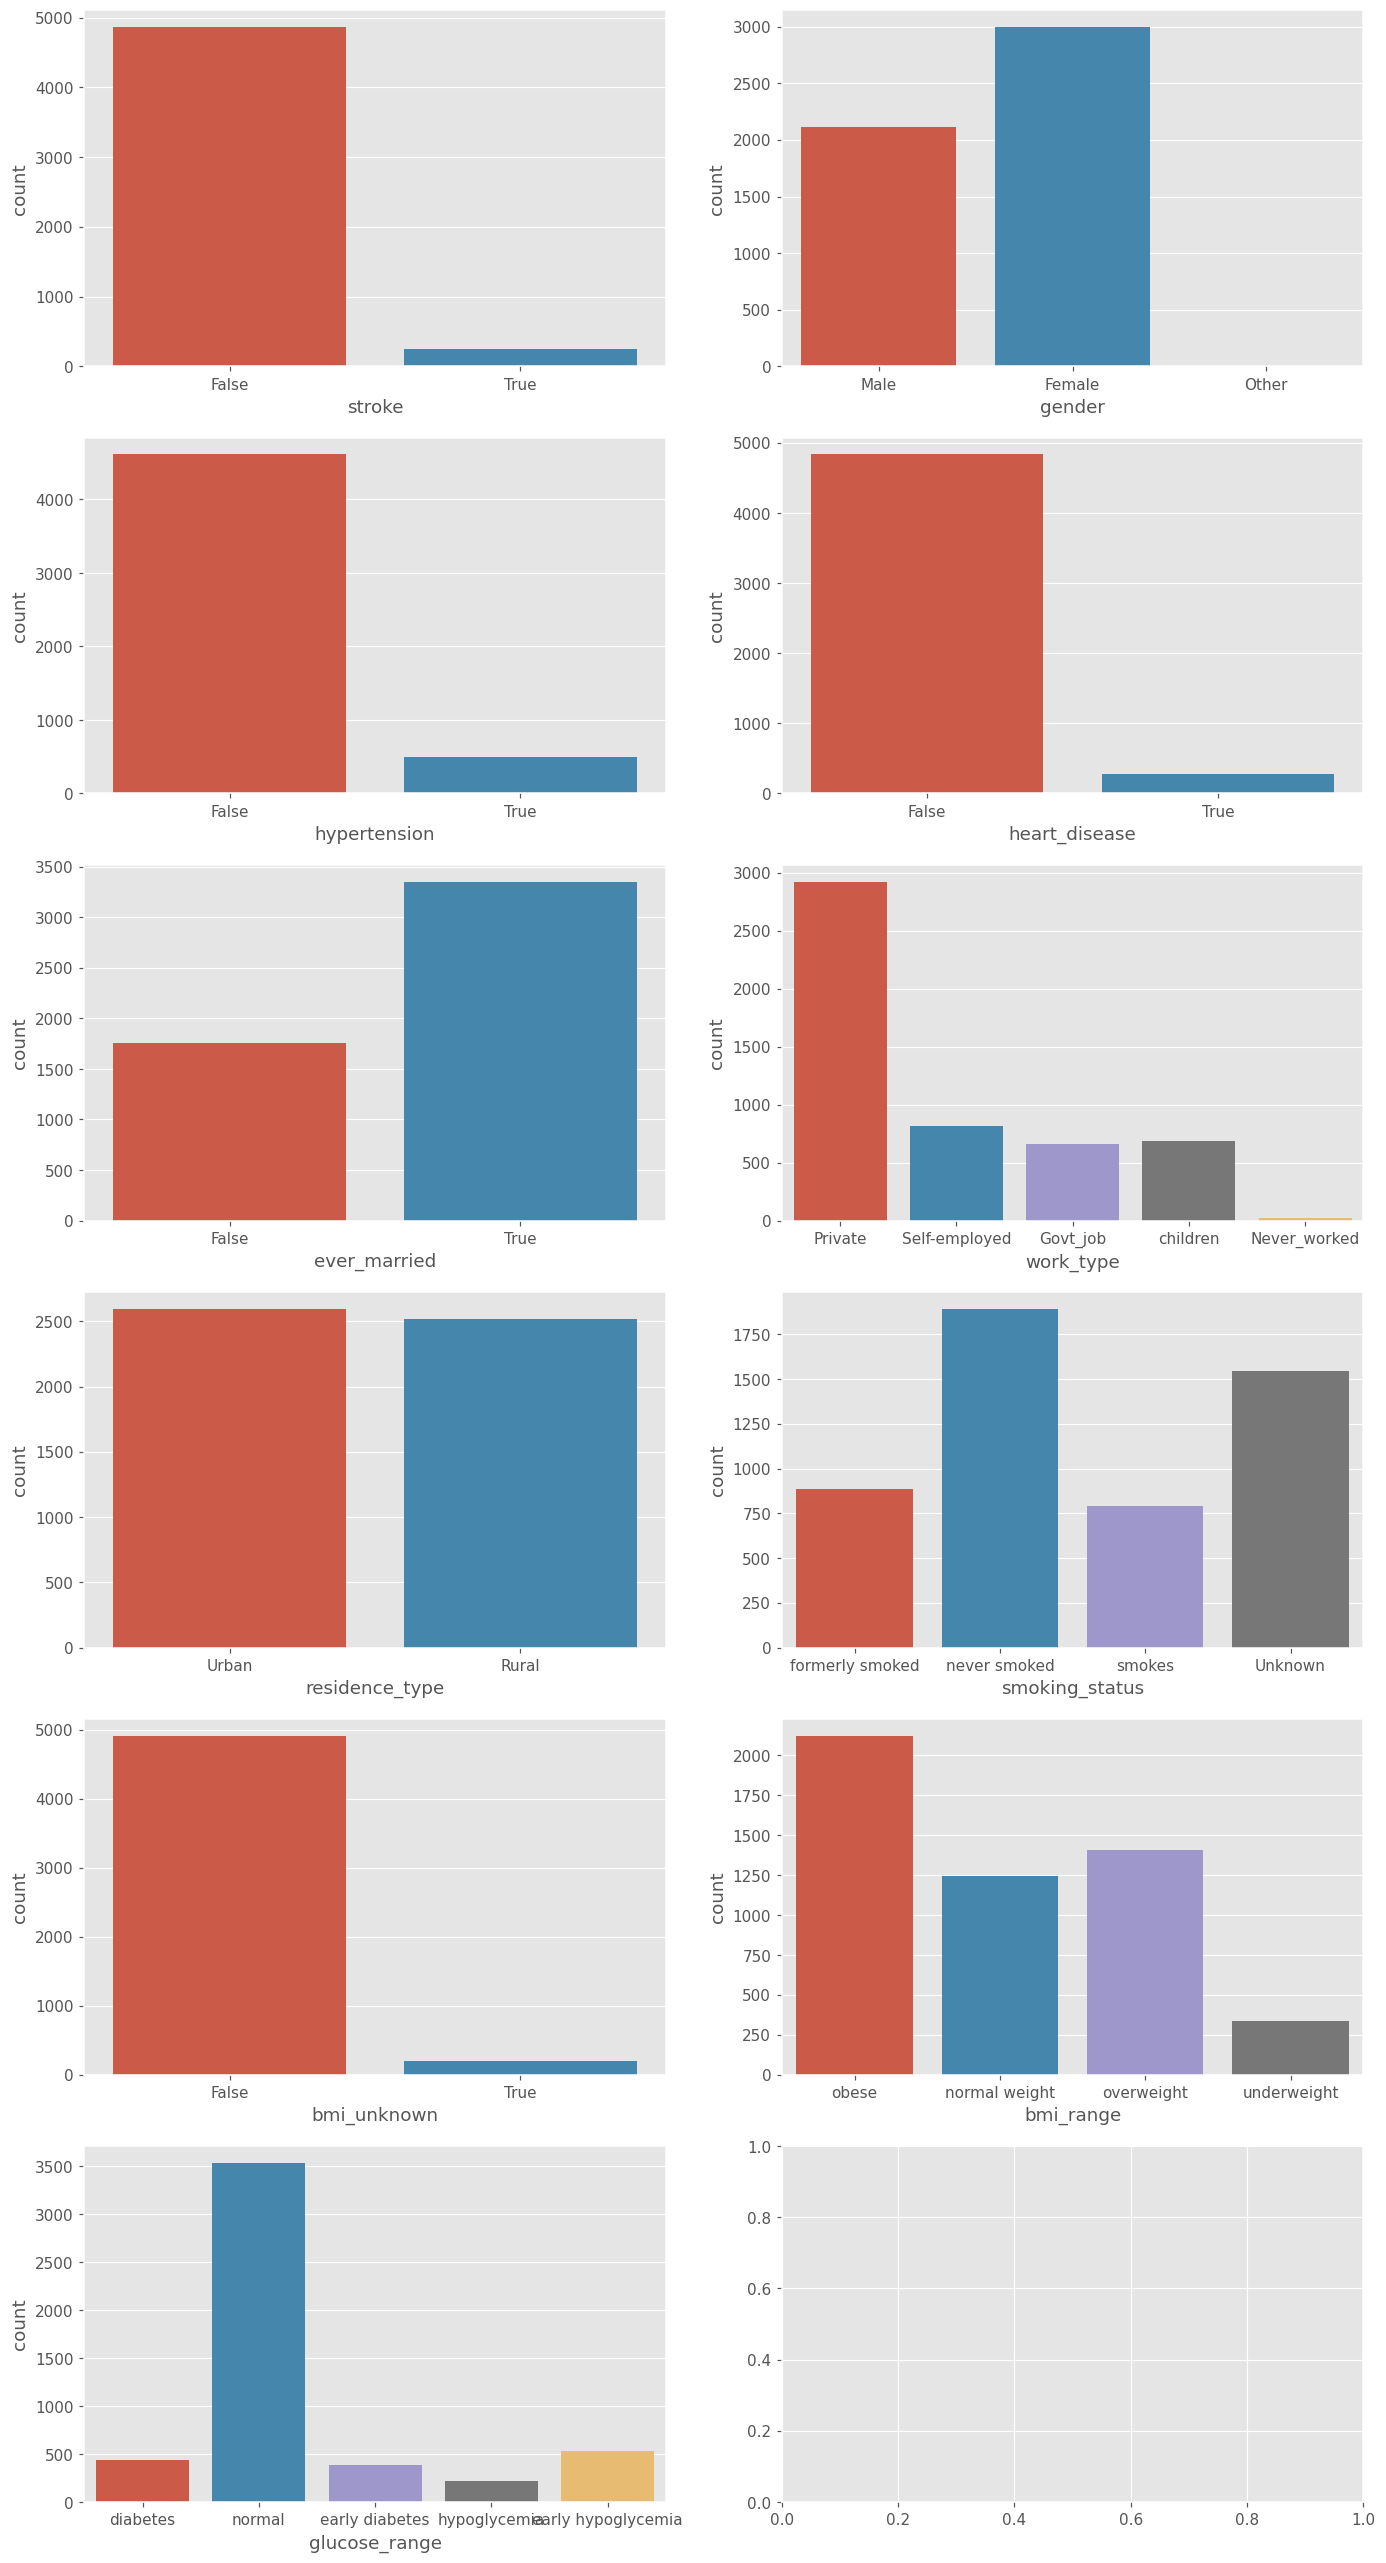

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=6, figsize=(15, 30))
axs = axs.reshape(-1)
i = 0
for name in categorical:
    sns.countplot(x=name, ax=axs[i], data=df)
    i += 1

Wyświetlmy wszystkie obserwacje pacjentów, którzy nigdy nie palili

In [12]:
df[df.work_type == 'Never_worked']

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_range,glucose_range,bmi_unknown
253,Male,14.0,False,False,False,Never_worked,Rural,161.28,19.1,Unknown,False,normal weight,early diabetes,False
603,Male,23.0,False,False,False,Never_worked,Urban,125.26,18.7,never smoked,False,normal weight,normal,False
886,Female,19.0,False,False,False,Never_worked,Urban,86.96,25.8,never smoked,False,overweight,normal,False
939,Male,13.0,False,False,False,Never_worked,Rural,111.48,20.8,Unknown,False,normal weight,normal,False
959,Male,17.0,False,False,False,Never_worked,Urban,113.25,23.4,never smoked,False,normal weight,normal,False
1462,Male,17.0,False,False,False,Never_worked,Rural,61.01,32.5,Unknown,False,obese,early hypoglycemia,False
1789,Female,13.0,False,False,False,Never_worked,Urban,70.93,22.9,never smoked,False,normal weight,normal,False
1922,Male,16.0,False,False,False,Never_worked,Urban,59.99,28.2,never smoked,False,overweight,hypoglycemia,False
2346,Female,14.0,False,False,False,Never_worked,Urban,148.37,22.7,never smoked,False,normal weight,early diabetes,False
2721,Female,17.0,False,False,False,Never_worked,Rural,88.57,31.1,never smoked,False,obese,normal,False


Tak jak wspomniane w opisie atrybutów, wbrew pozorom, wartość kolumny "work type" równa "children" nie oznacza pracy z dziećmi (np. opiekun, rodzic), ale fakt bycia dzieckiem! Zweryfikujmy to rysując histogram wieku rzędów z tym "work type". Ta informacja była pominięta w źródle danych!

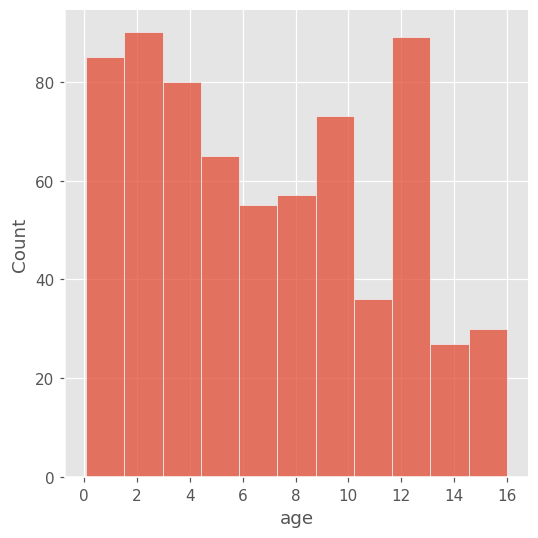

In [13]:
sns.displot(df[df.work_type == 'children'].age)

Nieintuicyjne wydaje się też przypisanie większości nieletnim statusu palenia "Unknown". W poniższej tabelce i na wykresie przedstawiono informacje o tym ilu pacjentów o danym wieku **lub poniżej**, ma przypisany konkretny status. Na szczęście nie odnotowano 9-laktów palaczy (chociaż są niewiadome), ale już kilka 10-letnich i kilkanaście/kilkadziesiąt nastoletnich dzieci pali. Nie wiadomo co jednak zrobić z wartościami "Unknown". Nie wiemy wystarczająco o procesie zbierania danych i ich źródle, żeby założyć, że "Unwnown" to praktycznie "never smoked".

,formerly smoked,never smoked,smokes,Unknown
9,0,0,0,472
10,4,5,1,497
11,5,16,1,521
12,10,29,2,547
13,12,45,3,585
14,17,65,3,614
15,19,87,3,635
16,21,113,5,657
17,25,140,9,682
18,28,165,14,709


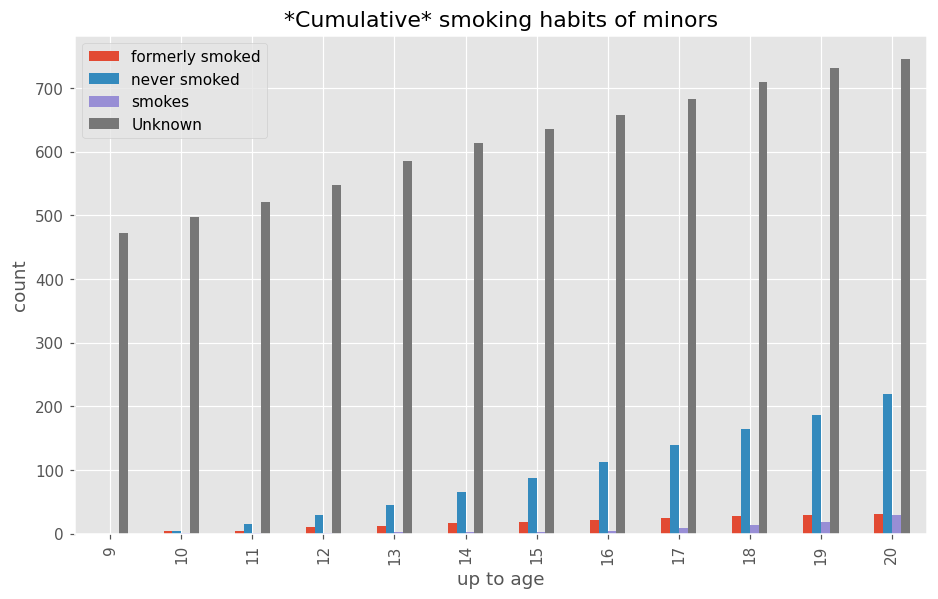

In [14]:
ages = range(9, 21)
data = [{k: sum((df.age <= age) & (df.smoking_status == k)) for k in df.smoking_status.unique()} for age in ages]
data = pd.DataFrame(data, index=ages)
data.plot.bar()
plt.title('*Cumulative* smoking habits of minors')
plt.xlabel('up to age')
plt.ylabel('count')
data

## Atrybuty ilościowe

Są tylko trzy atrybuty ilościowe: wiek, bmi i avg_glucose_level. Poniżej zamieściliśmy ich histogramy oraz wizualizacje łącznych rozkładów (parami).

**Wnioski**

- Wiek poniżej 2 lat może mieć część ułamkową - małe dzieci mają bardziej precyzyjnie obliczany wiek (nie wiadomo czy tygodnie czy miesiące).
- Wiek powyżej 2 lat ma tylko część całkowitą.
- Rozkład wieku jest w miarę równomierny, z lekką przewagą pacjentów w średnim wieku
- Rozkład BMI jest zbliżony do normalnego ze średnią 28.9 (nadwaga!) 
- Rozkład poziomu glukozy we krwi jest bimodalny - jedna moda około 80-100 (prawidłowy poziom), druga moda koło 200 (cukrzyca) 

In [15]:
numerical = ['age', 'bmi', 'avg_glucose_level']
df[numerical].agg(['min', 'median', 'max', 'mean', 'std']).T

,min,median,max,mean,std
age,0.08,45.000,82.00,43.226614,22.612647
bmi,10.30,28.100,97.60,28.893237,7.854067
avg_glucose_level,55.12,91.885,271.74,106.147677,45.283560


In [16]:
print(sorted(df.age.unique()))

[0.08, 0.16, 0.24, 0.32, 0.4, 0.48, 0.56, 0.64, 0.72, 0.8, 0.88, 1.0, 1.08, 1.16, 1.24, 1.32, 1.4, 1.48, 1.56, 1.64, 1.72, 1.8, 1.88, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0]


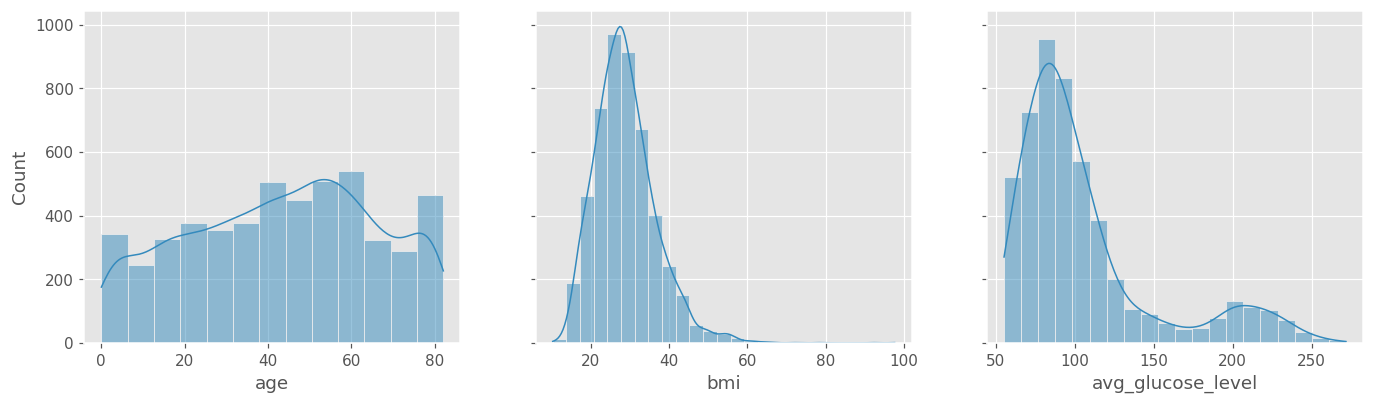

In [17]:
bins = 13, 25, 20
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15, 4))
for ax, col, bin in zip(axs, numerical, bins):
    sns.histplot(x=col, data=df, bins=bin, kde=True, ax=ax)

## Szukanie zależności

### 1. Korelacje

**Wnioski**

- Z łącznego porównania rozkładów (z podziałem na atrybucie decyzyjnym) nie wyczytałem dodatkowych informacji
- Z macierzy korelacji można wyczytać, że wiek jest skorelowany z zawarciem małżeństwa, co było do przewidzenia - dzieci nie biorą ślubów, młodzi dorośli raczej nie, a poźniej z wiekiem coraz więcej ludzi bierze
- BMI, poziom glukozy, choroba serca, nadciśnienie i udar są wszystkie dodatnio skorelowane z wiekiem (współczynnik wynoszi 0.24-0.33)

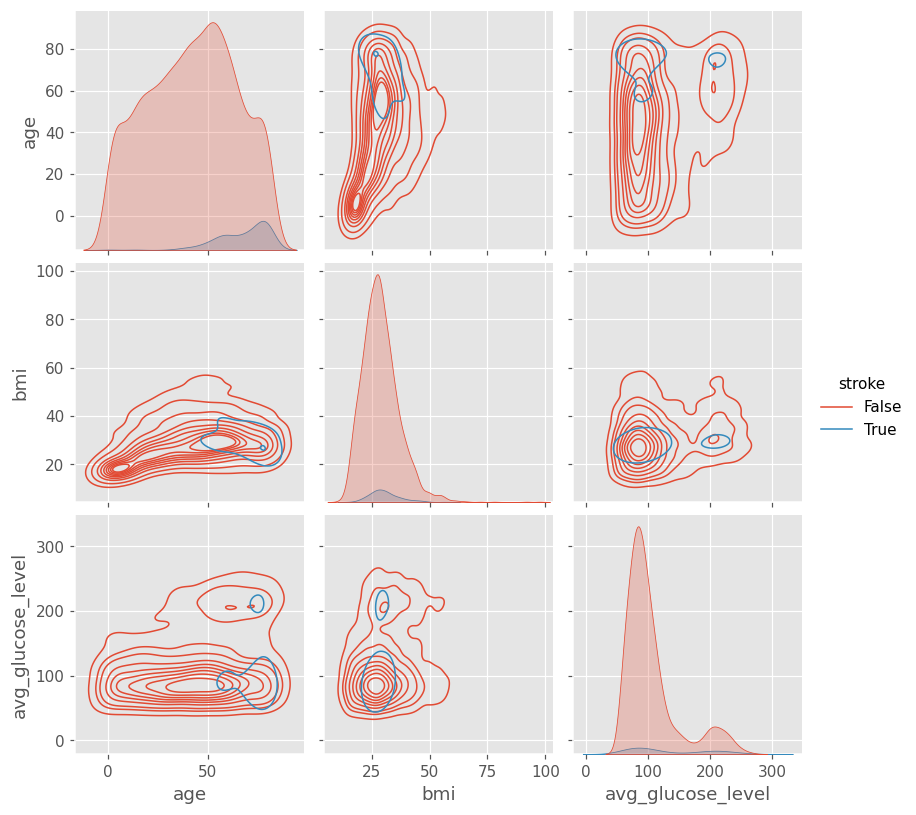

In [18]:
sns.pairplot(df[['age', 'bmi', 'avg_glucose_level', 'stroke']], kind='kde', hue='stroke')

<AxesSubplot:>

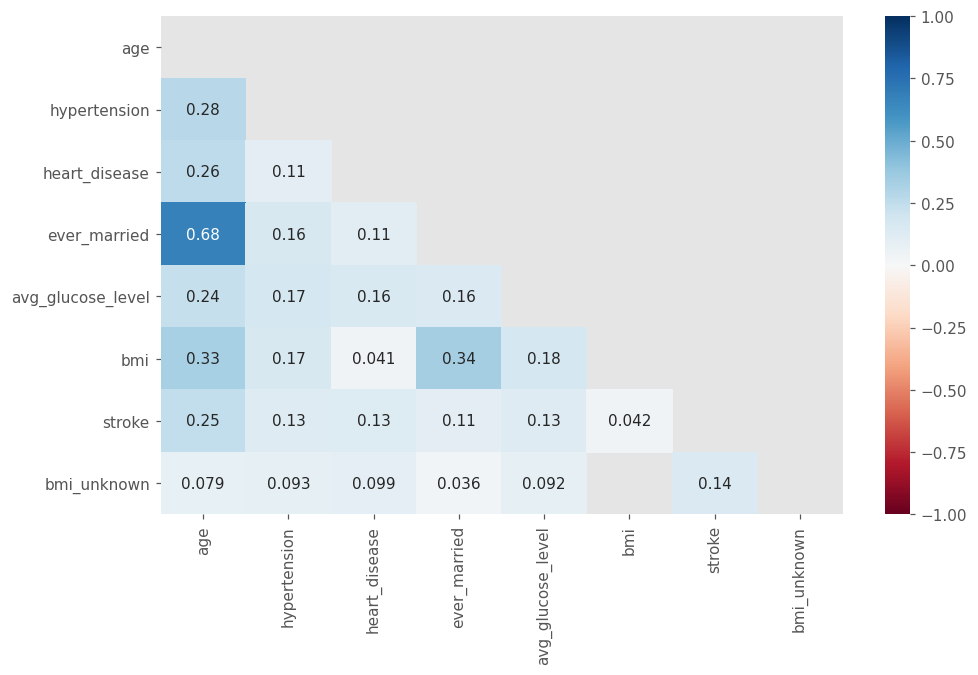

In [19]:
corr = df.corr()
sns.heatmap(corr, mask=np.triu(np.ones_like(corr)), annot=True, cmap='RdBu', vmin=-1, vmax=1)

### 2. Rozkłady z podziałem na atrybucie decyzyjnym

**Wnioski**

Rysowanie oddzielnie rozkładów atrybutów ilościowych w zależności od wartości atrybutu decyzyjnego jasno pokazało bardzo zależność pomiędzy starszym wiekiem a doznaniem udaru.

Rozkłady BMI się w znaczej części pokrywają, z tym, że dla udaru, jest bardziej przesunięty w stronę otyłości, co też wydaje się intuicyjne.

Rozkład poziomu glukozy dla udaru ma większą gęstość w zakresie wczesnej cukrzycy/cukrzycy, a mniejszą w zakresie normy i poniżej.

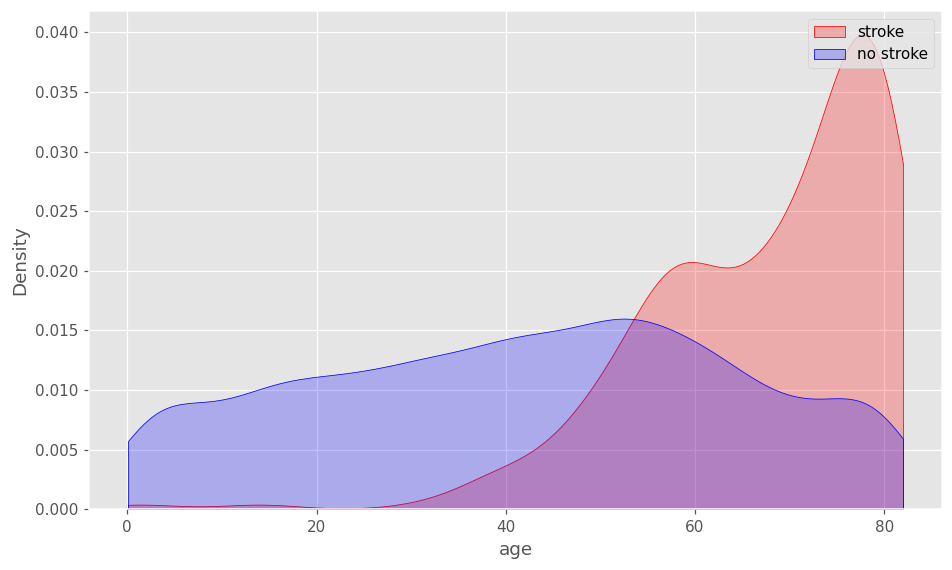

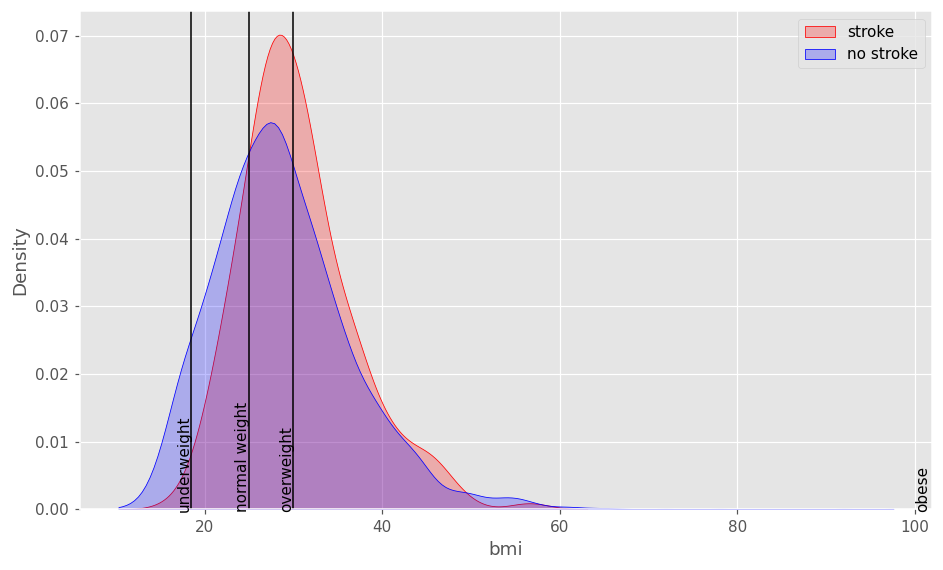

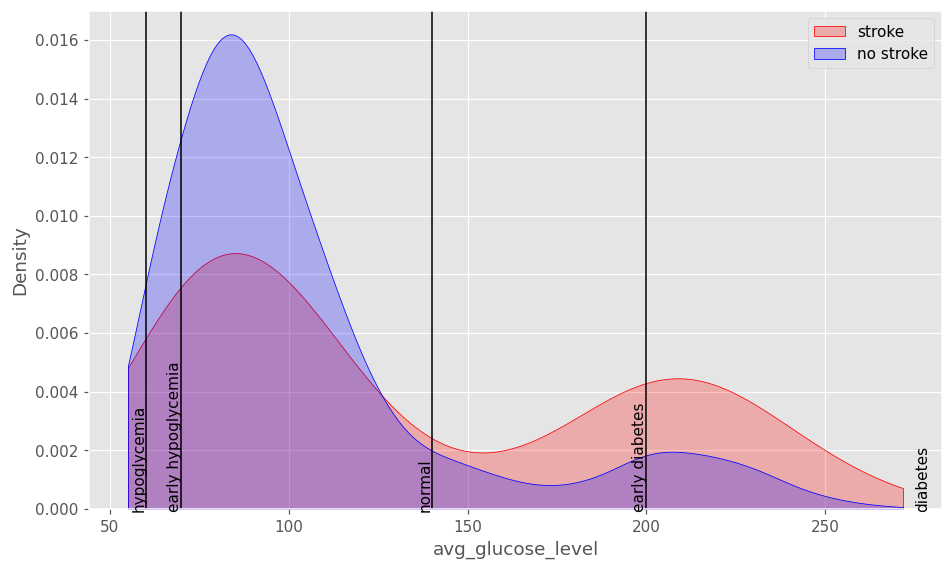

In [20]:
for variable in ['age', 'bmi', 'avg_glucose_level']:
    mini, maxi = df[variable].min(), df[variable].max()
    args = dict(shade=True, clip=(mini, maxi))
    fig, ax = plt.subplots()
    sns.kdeplot(x=variable, data=df[df.stroke], color='red', label='stroke', **args)
    sns.kdeplot(x=variable, data=df[~df.stroke], color='blue', label='no stroke', **args)
    if variable == 'bmi':
        for x, l in bmi_ranges[:-1]:
            plt.axvline(x, color='k')
            plt.annotate(l, (x-1.6, 0), rotation=90)
        plt.annotate('obese', (100, 0), rotation=90)
        
    if variable == 'avg_glucose_level':
        for x, l in blood_sugar_levels[:-1]:
            plt.axvline(x, color='k')
            plt.annotate(l, (x-4, 0), rotation=90)
        plt.annotate('diabetes', (275, 0), rotation=90)
        
    plt.legend()

### 3. Prawdopodobieństwo warunkowe

Zależności pomiędzy atrybutami nominalnymi i binarnymi zwizualizowaliśmy jako wykresy słupkowe prawdopodobieństwa danej wartości atrybutu pod warunkiem zaobserwowania udaru (np. $P(\text{heart_disease}=1|\text{stroke}=\text{1})$).

Prawdopodobieństwo warunkowe liczymy bezpośrednio z poniższego wzoru.

$$P(A|B) = \frac{P(A \cap B)}{P(B)}$$

Dla niektórych klasyfikatorów, obserwacja, że $P(\text{stroke}|\text{heart_disease})$ > $P(\text{stroke}|\lnot \text{heart_disease})$ może być przydatna do *predykcji* prawdopodobieństwa doznania udaru.
Przy analizie danych musimy się jednak powstrzymać od pochopnych wniosków. Taka obserwacja nie musi oznaczać, że choroby serca *powodują* udary. Eksperymentalnie, dla naszego przykładu, zachodzi też $P(\text{heart_disease}|\text{stroke}) > P(\text{heart_disease}|\lnot \text{stroke})$. Czy w takim razie choroby serca serca powodują udar, czy udar choroby serca, a może jest jakaś ukryta zmienna? Z warunkowego prawdopodobieństwa się tego nie dowiemy, a jedynie możemy uzyskać fajny klasyfikator. Żeby zbadać przyczynowość musielibyśmy przeprowadzić prawdziwy zrandomizowany eksperyment.

In [21]:
sum(df.stroke & df.heart_disease) / sum(df.heart_disease) > sum(df.stroke & ~df.heart_disease) / sum(~df.heart_disease)

True

In [22]:
sum(df.heart_disease & df.stroke) / sum(df.stroke) > sum(df.heart_disease & ~df.stroke) / sum(~df.stroke)

True

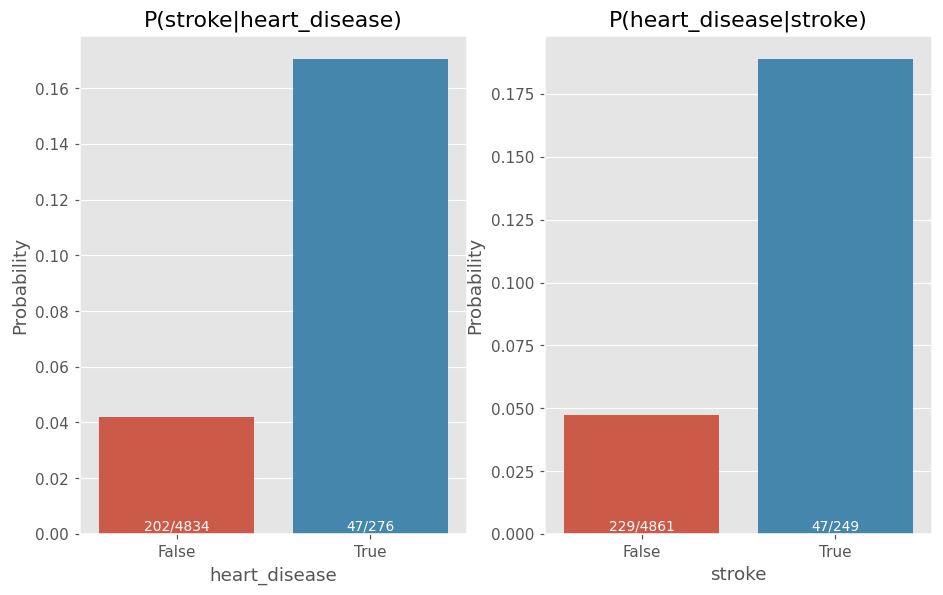

In [23]:
def plot_conditional(variable, condition, ax):
    count = df[condition].value_counts()
    prob = df[df[variable]][condition].value_counts() / count
    barplot = sns.barplot(x=prob.index, y=prob, ax=ax)
    for n1, n2, p, pp in zip(prob, count, barplot.patches, prob):
        barplot.annotate(f'{n1*n2:.0f}/{n2:.0f}',
           (p.get_x() + p.get_width() / 2., 0), 
           xytext = (0, 10), color='white', size=9,
           ha='center', va='top', textcoords='offset points') 
    ax.set_title(f'P({variable}|{condition})')
    ax.set_ylabel('Probability')
    ax.set_xlabel(condition)
    
fig, (ax1, ax2) = plt.subplots(ncols=2)
plot_conditional('stroke', 'heart_disease', ax1)
plot_conditional('heart_disease', 'stroke', ax2)

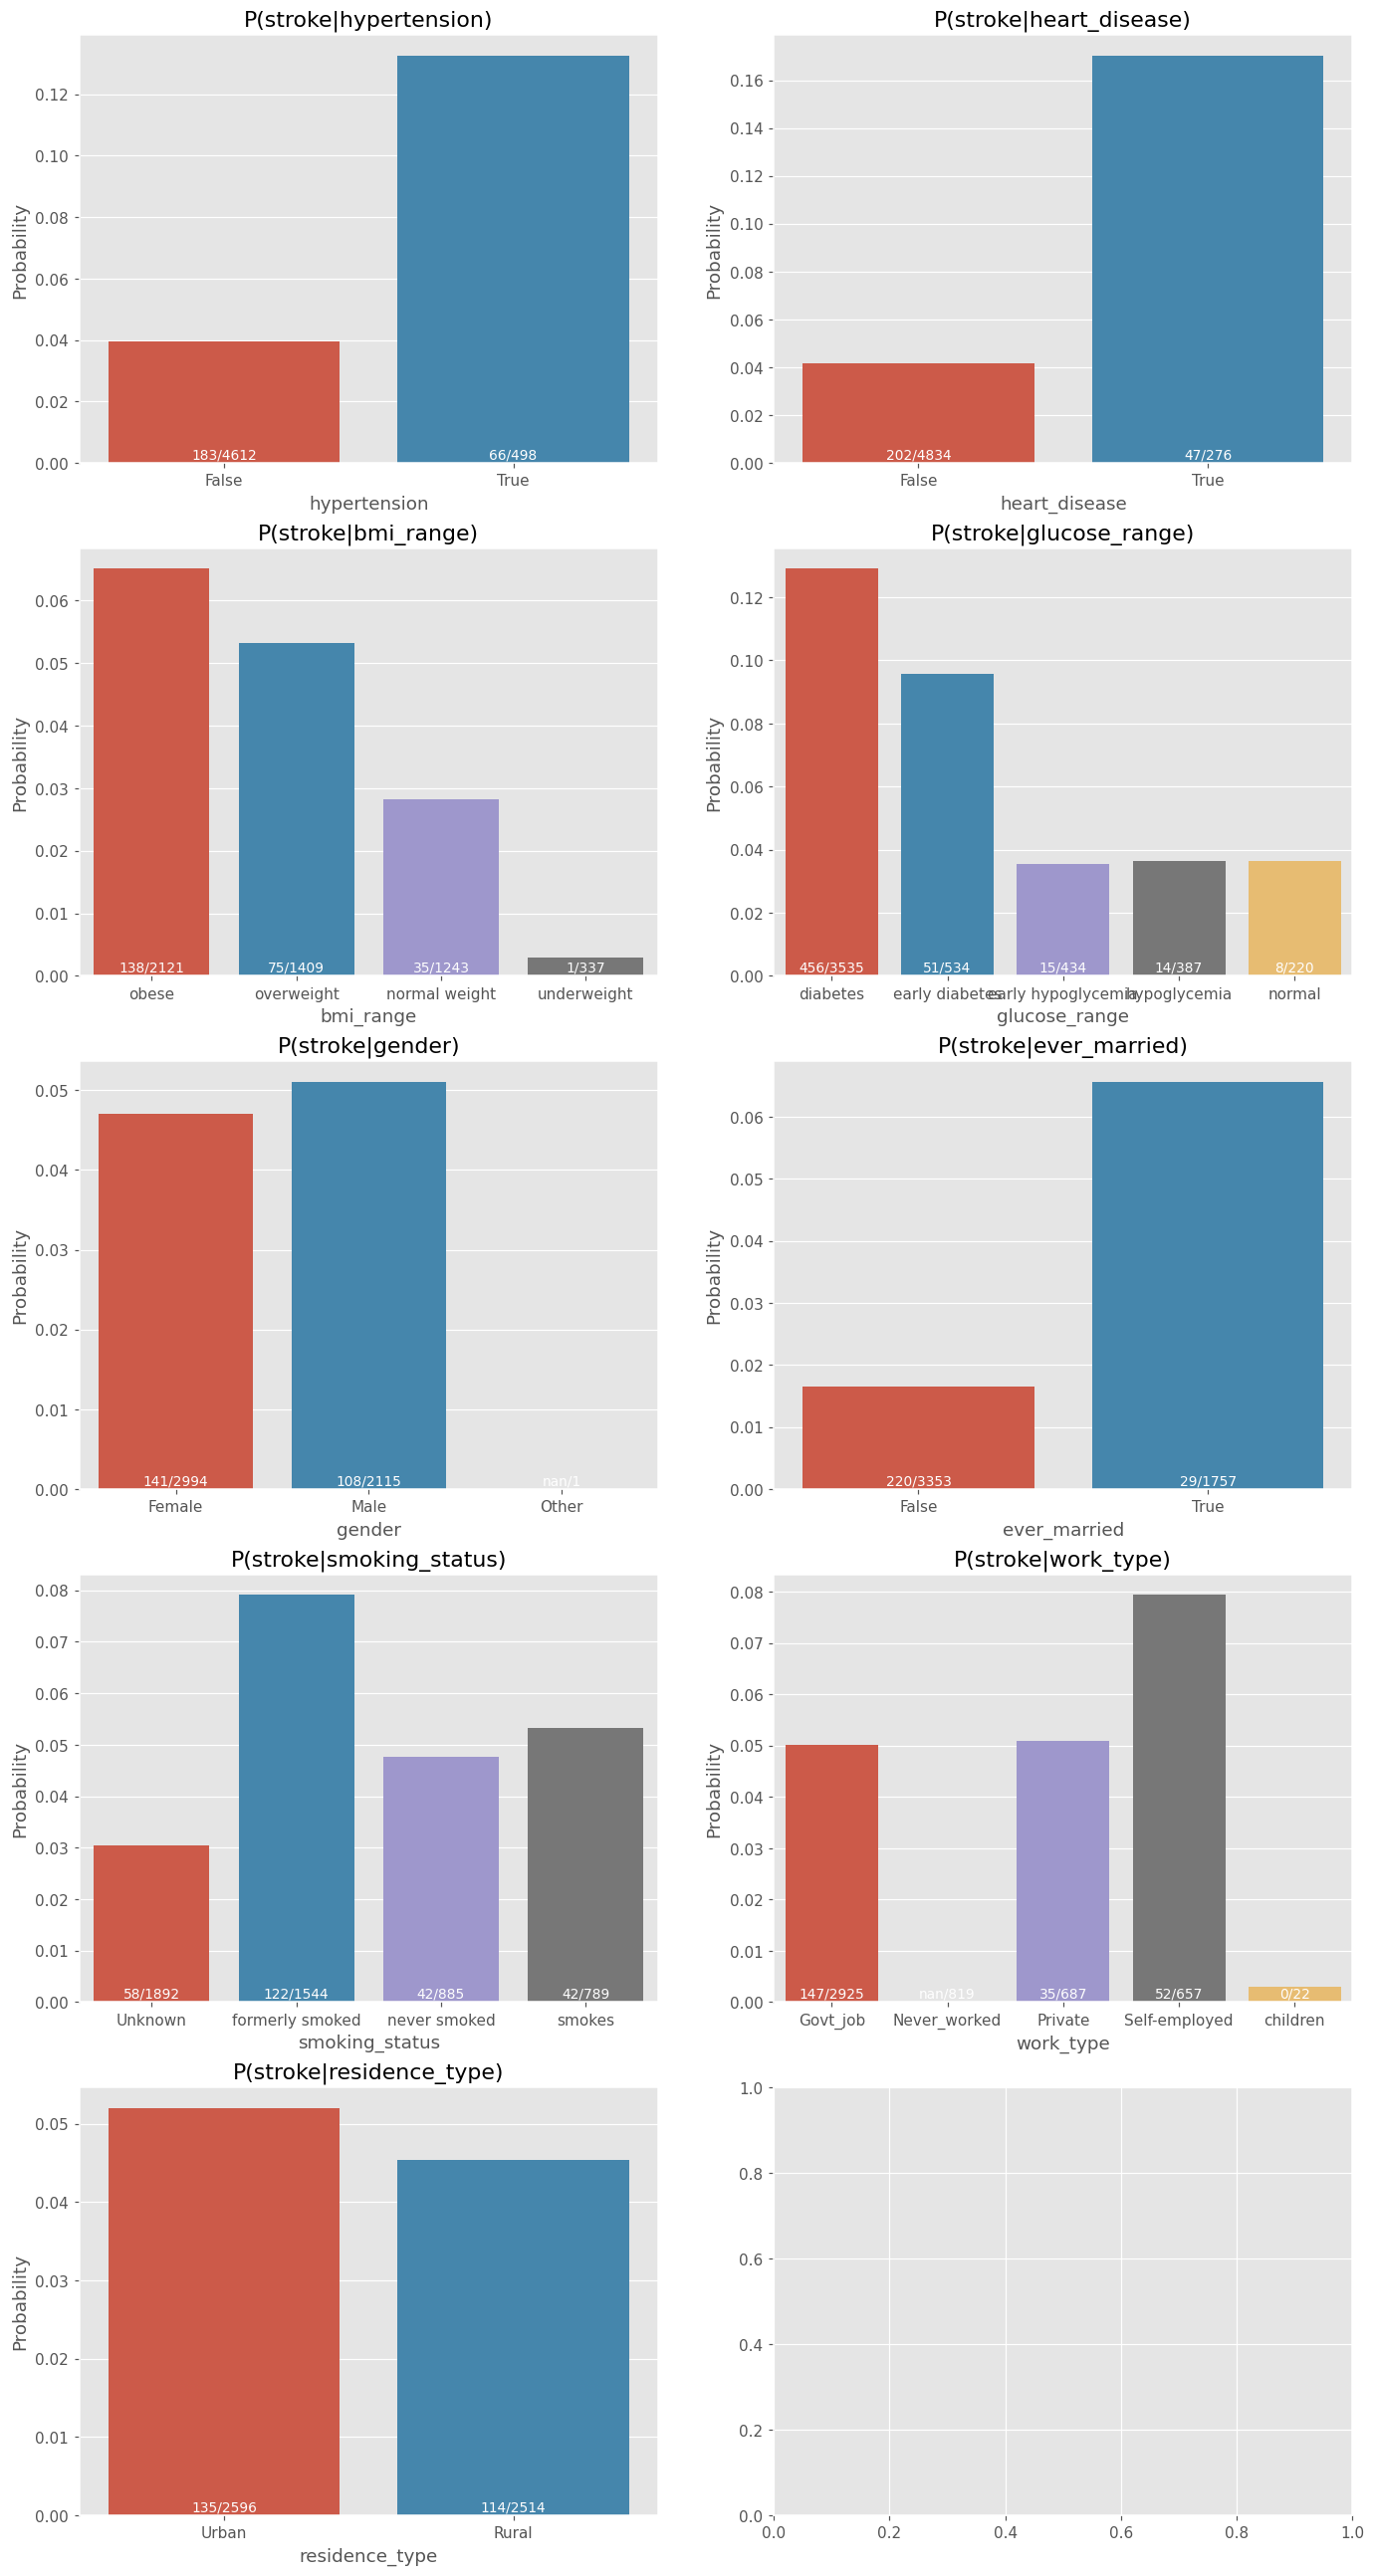

In [24]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(15, 30))
axs = axs.reshape(-1)
i = 0
for disease in ['stroke']:
    for condition in ['hypertension', 'heart_disease', 'bmi_range', 'glucose_range', 'gender', 'ever_married', 'smoking_status', 'work_type', 'residence_type']:
        plot_conditional(disease, condition, ax=axs[i])
        i += 1

**Wnioski**

- W zbiorze jest większa proporcja osób po udarze, mieszkających w mieście niż na wsi (około 0.5% więcej)
- Jest o wiele większa proporcja osób po udarze, które kiedyś paliły od osób które nigdy nie paliły, albo palą.
- Najmniejsza proporcja osób po udarze była dla osób z niewiadomą historią palenia - możliwie dlatego, bo w zbiorze jest dużo nieletnich z tą wartością statusu palenia, a nieletni *raczej* nie palą.
- Żaden nieletni *oznaczony w atrybucie "work_type"* nie doświadczył udaru.
- 3% więcej osób po udarze było samozatrudnionych niż zatrudnionych przez rząd albo prywatnie.
- Prawie 5% większa jest proporcja osób po udarze i ślubie, niż bez ślubu - możliwie dlatego, bo po ślubie osoby są w starszym wieku, a myślę, że raczej starszy wiek powoduje udar, a nie ślub.
- Jest o prawie 0.5% większa proporcja mężczyzn z udarem niż kobiet z udarem
- Jest o 12% większa proporcja osób z udarem pod warunkiem, że mieli chorobę serca, niż osób z bez choroby serca
- Podobnie, 8% większa proporcja osób z nadciśnieniem i udarem, niż z udarem pod warunkiem braku nadciśnienia
- Podobnie, 6%/9% większa proporcja dla osób z wczesną cukrzycą/cukrzycą vs osoby w normie i z hipoglikemią
- Podobnie, 2%/3% większa proporcja dla osób z nadwagą/otyłością vs osoby w normie
- Tylko jedna na 337 osób z niedowagą doznała udaru

# Klasyfikacja

Do klasyfikacji użyliśmy trzech algorytmów: gaussowskiego naiwnego Bayesa, regresji logistycznej i drzewa decyzyjnego

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer, plot_confusion_matrix, plot_roc_curve, roc_auc_score, accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.metrics import geometric_mean_score, sensitivity_score, specificity_score
from imblearn.over_sampling import SMOTE

Na początku usuwamy jedną obserwację z gdzie "gender" jest równe "Other" i uzupełniamy brakujące wartości BMI medianą.

Zbiór dzielimy funkcją `train_test_split` na treningowy-walidacyjny (3/4) i testowy (1/4) ze stratyfikacją.

W zbiorze treningowym i walidacyjnym w sumie znajduje się 3831 obserwacji, a w zbiorze testowym  1703 obserwacje.

In [26]:
SEED = 1337

numerical_cols = ['age', 'avg_glucose_level', 'bmi']
categorical_cols = ['gender', 'work_type', 'residence_type', 'smoking_status']
binary_cols = ['bmi_unknown', 'hypertension', 'heart_disease', 'ever_married']

ds = df.copy()
ds = ds[ds.gender != 'Other']
ds.bmi = ds.bmi.fillna(ds.bmi.median())
X = ds.drop(columns=['stroke'])
X = X[binary_cols + categorical_cols + numerical_cols]
y = ds.stroke
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=1/4, stratify=y, random_state=SEED)

print('train+val', len(y_tr))
print('test', len(y_te))

train+val 3831
test 1278


Używamy algorytmów przy pomocy klasy `Pipeline` z scikit-learn. Na początku potoku przetwarzania kodujemy cechy nominalne (ale nie binarne) jako wektory one-hot klasą `OneHotEncoder`. Później normalizujemy kolumny numeryczne klasą `StandardScaler`. Wyboru transformacji w zależności od typu kolumny dokonuje `ColumnTransformer`. Dodatkowo stosujemy oversampling metodą SMOTE (z pakietu imbalanced-learn) z domyślnymi parametrami.

Do oceny jakości klasyfikatora, na zbiorze treningowym wykonujemy stratyfikowaną walidację krzyżową na 20-foldach i obliczamy wartości metryk ROC AUC, średnią geometryczną i dokładność.

Na końcu uczymy klasyfikator na całym zbiorze uczącym i obliczamy metriki dla predykcji ze zbioru testowego. Rysujemy też krzywą ROC i macierze pomyłek z proporcją dobrze zaklasyfikowanych wartości atrybutu decyzyjnego **dla zbioru testowego**.

In [27]:
metrics = ['roc_auc', 'g_mean', 'accuracy']
    
def make_clas(clas, onehot=False, scale=False, smote=False):
    encode = OneHotEncoder() if onehot else OrdinalEncoder()
    transforms = [('encode', encode, categorical_cols)]
    if scale: transforms += [('scale', StandardScaler(), numerical_cols)]
    steps = [('preproc', ColumnTransformer(transforms, remainder='passthrough'))]
    if smote: steps += [('smote', SMOTE(random_state=SEED))]
    steps += [('classifier', clas)]
    return Pipeline(steps)

def cv_model(model, X, y):
    return cross_validate(model, X_tr, y_tr, cv=20, n_jobs=4,
        scoring=dict(roc_auc=make_scorer(roc_auc_score), g_mean=make_scorer(geometric_mean_score), accuracy=make_scorer(accuracy_score)),
        return_train_score=True, return_estimator=True)

def cv_report(results, model_name):
    res = []
    data = {}
    for metric in metrics:
        xs = results['test_'+metric]
        data[metric] = xs
        res += [dict(mean=np.mean(xs), std=np.std(xs))]
    res = pd.DataFrame(res, index=metrics)
    print(res)
    data = pd.DataFrame(data)
    data['model'] = model_name
    return data
    
def test_model(model, model_name):
    model.fit(X_tr, y_tr)
    plot_confusion_matrix(model, X_te, y_te, cmap='BuGn', normalize='true')
    plt.grid(False)
    plot_roc_curve(model, X_te, y_te)
    Y_te = model.predict_proba(X_te)[:,1]
    return dict(model=model_name, roc_auc=roc_auc_score(y_te, Y_te), g_mean=geometric_mean_score(y_te, Y_te > 0.5), accuracy=accuracy_score(y_te, Y_te > 0.5))

## Naive Bayes

Naiwny Bayes (ze skalowaniem i SMOTE, ale bez kodowania one-hot, bo z nim radził sobie gorzej) poprawnie klasyfikuje 81% przypadków udaru na zbiorze testowym. 19% to false negative (całkiem sporo - gorzej powiedzieć narażonemu, że będzie zdrowy, niż zdrowemu, że może być narażony).

              mean       std
roc_auc   0.736106  0.070977
g_mean    0.731967  0.075197
accuracy  0.750697  0.035170


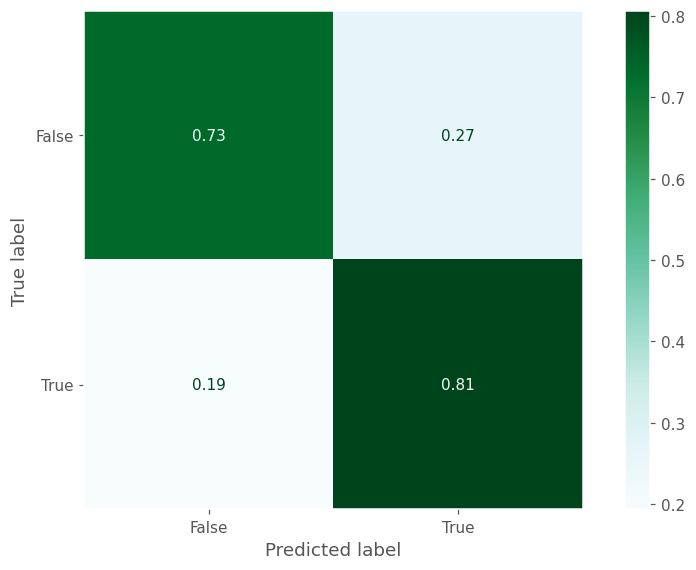

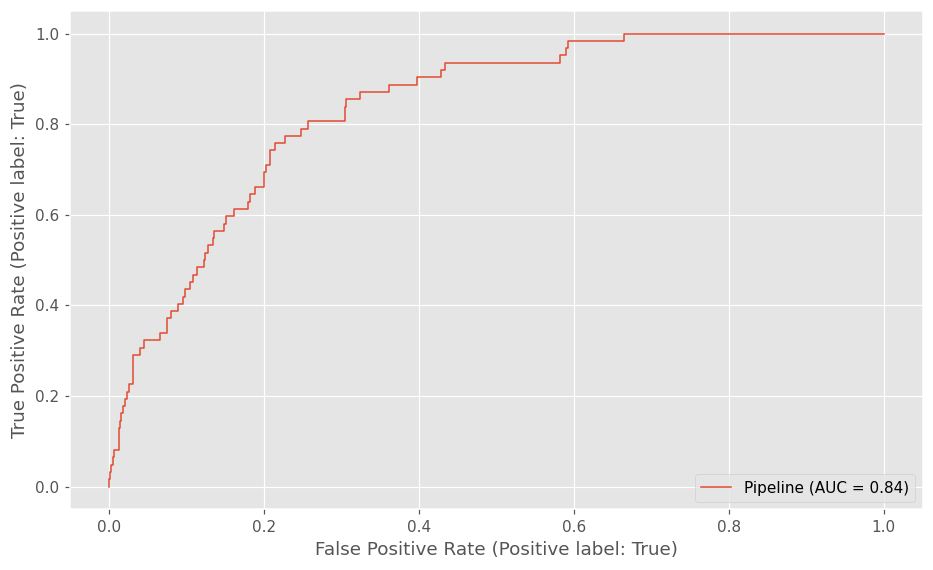

In [28]:
model = make_clas(GaussianNB(), onehot=False, scale=True, smote=True)
results = cv_model(model, X_tr, y_tr)
report1 = cv_report(results, 'Naive Bayes')
test1 = test_model(model, 'Naive Bayes')

Klasyfikator bez SMOTE osiąga średnio około 12% większą dokładność na zbiorze treningowym, przy około 12% niższych AUROC i gmean, czego się spodziewaliśmy, biorąc pod uwagę niezbalansowanie klas.

In [29]:
model1a = make_clas(GaussianNB(), onehot=False, scale=True, smote=False)
results1a = cv_model(model1a, X_tr, y_tr)
report1a = cv_report(results1a, 'Naive Bayes (no SMOTE)')

              mean       std
roc_auc   0.661597  0.079953
g_mean    0.602275  0.132266
accuracy  0.875225  0.019354


## Regresja Logistyczna

Regresja logistyczna z ustawieniem `class_weight='balanced'`, SMOTE, normalizacją i kodowaniem one-hot uzyskuje lepsze wyniki niż naiwny Bayes. 3% mniej false negatives i 2% mniej false positives. 

Dotatkowo, możemy interpretować wagi kombinacji liniowej atrybutów. Wagi atrybutów przedstawione na wykresie poniżej krzywej ROC. Największą wagę ma atrybut "smoking_status" dla wartości "smokes" - nie jestem zaskoczony, palenie szkodzi zdrowiu. Drugą największą wagę ma "Unknown" dla "smoking_status", co było zaskoczeniem. Pomijając nieletnich o których nie wiemy czy palą (ale podejrzewam, że raczej nie palą), może dorośli którzy mają "Unknown" nie chcieli się przyznać do nawyku? A może to dlatego bo smoking_status = "Unknown" jest najwięcej w zbiorze. Nieintuicyjna jest też dla mnie wysoka waga "Govt_job" - z analiz prawdopodobieństwa warunkowego to wiedząc, że pacjent jest samozatrudniony jest większe prawdopodobieństwo że miał zawał, w porównaniu do pacjenta pracującego w sektorze publicznym. Pewnie wynika to z tego, że pacjentów pracujących w sektorze publicznym jest zdecydowanie więcej w zbiorze niż zatrudnionych w innych miejscach.

              mean       std
roc_auc   0.756007  0.063995
g_mean    0.752458  0.064644
accuracy  0.747324  0.026405


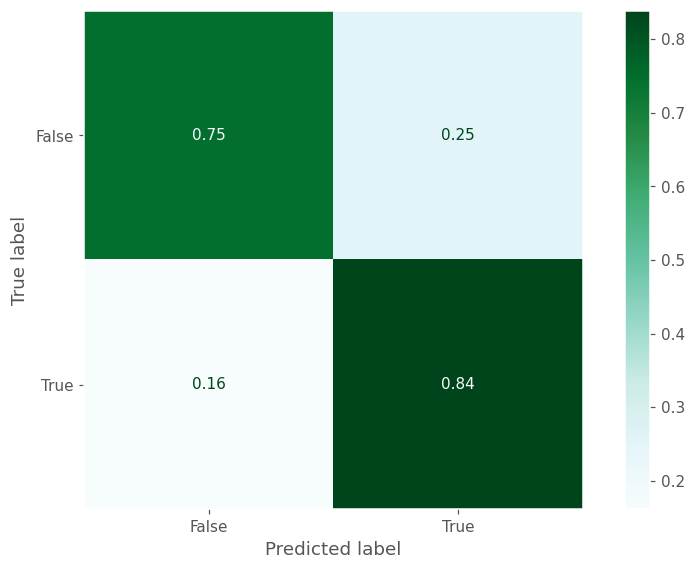

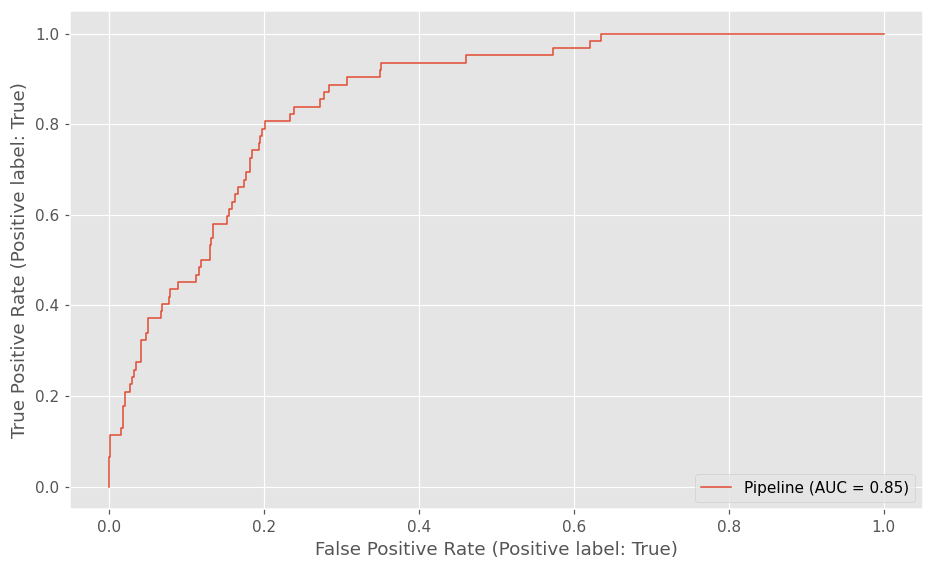

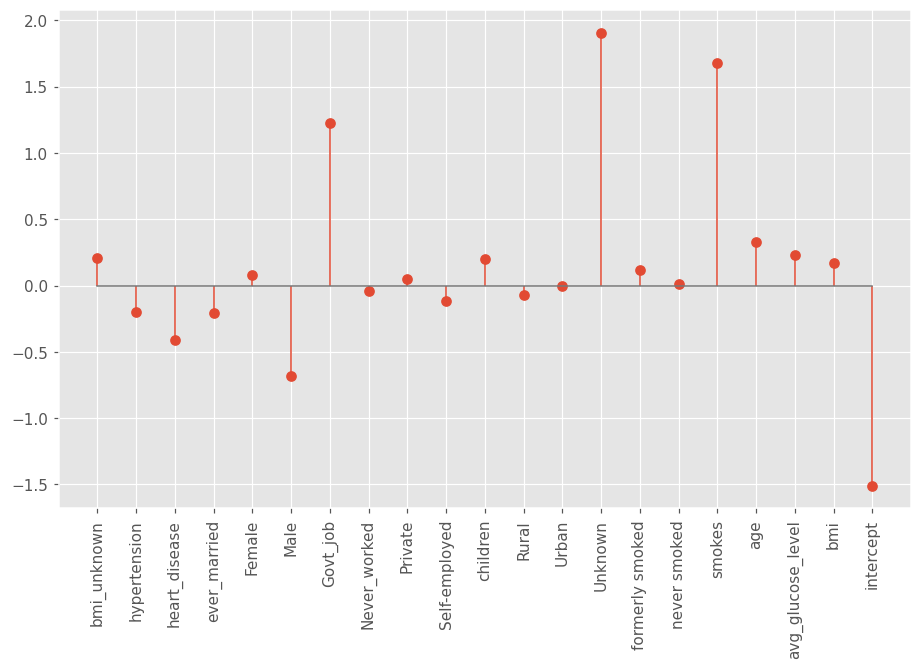

In [30]:
model = make_clas(LogisticRegression(class_weight='balanced'), scale=True, onehot=True, smote=True)
result = cv_model(model, X_tr, y_tr)
report2 = cv_report(result, 'Logistic Regression')
test2 = test_model(model, 'Logistic Regression')

ridge = model['classifier']
categories = model['preproc'].named_transformers_['encode'].categories_
names = binary_cols + [cat for cats in categories for cat in cats] + numerical_cols
plt.subplots()
plt.stem(list(names) + ['intercept'], list(ridge.coef_[0]) + [ridge.intercept_[0]])
plt.xticks(rotation=90)
plt.show()

## Drzewo decyzyjne

Drzewo decyzyjne z `scikit-learn`. Parametr `class_weight` ustawiony na `balanced`, współczynnik pruningu `ccp_alpha` ustawiony na 0.006 (dobrany eksperymentalnie), kodowanie cech nominalnych one-hot, bez normalizacji, bo drzewo tego nie powinno potrzebować. Nie wykorzystano SMOTE, bo oversampling skutkował niższymi wynikami w walidacji krzyżowej (tabela pod wizualizacją drzewa). Algorytm radzi sobie podobnie jak regresja logistyczna. Ma jednak 2% większy false negative rate i 1% mniejszy false positive rate.

Wizualizując drzewo decyzyjne można wyczytać następujące reguły:

- JEŻELI (wiek większy od 67.5) TO udar
- JEŻELI (wiek od 55.5 do 67.5) ORAZ (nie wiadomo czy osoba paliła LUB pacjent mieszka w mieście) TO udar
- WPW nie udar

**Wnioski**

- Wiek jest decydującym atrybutem
- Podobnie jak w regresji logistycznej: dziwne jest to, że drzewo się skupia na tym, że nie wiadomo, czy osoba paliła, a nie na pewnym oznaczeniem, że paliła ("smokes")
- Przypisanie klasy "stroke" starszym osobom mieszkającym w mieście może na przykład sugerować, że zanieczyszczone miejskie powietrze przyczynia się do udaru
- Biorąc pod uwagę prostotę reguł, drzewo może generalizować lepiej od poprzednich klasyfikatorów

              mean       std
roc_auc   0.723661  0.059138
g_mean    0.718061  0.062219
accuracy  0.742343  0.055378


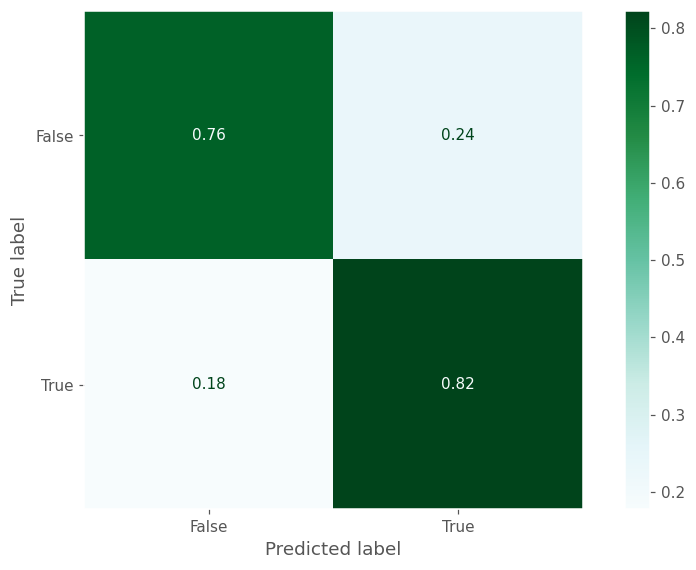

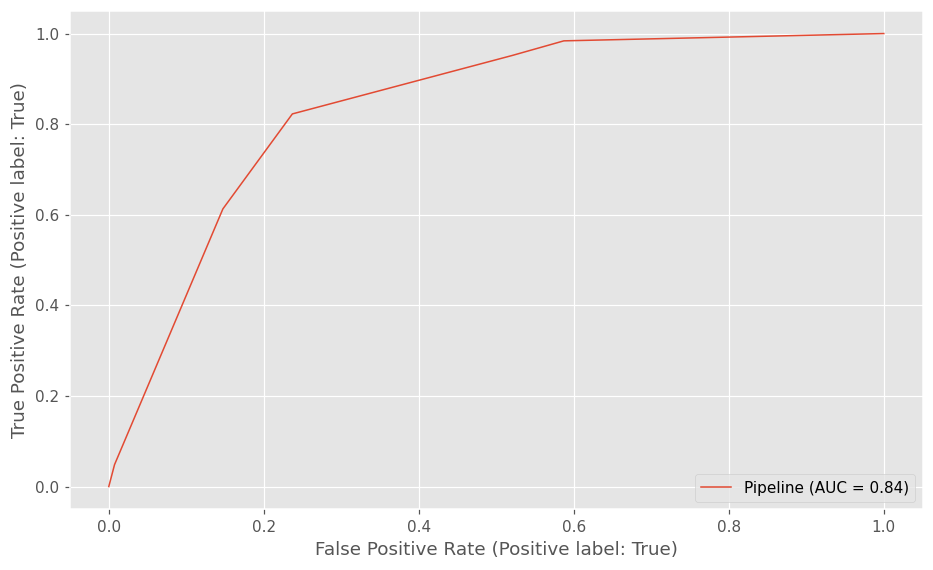

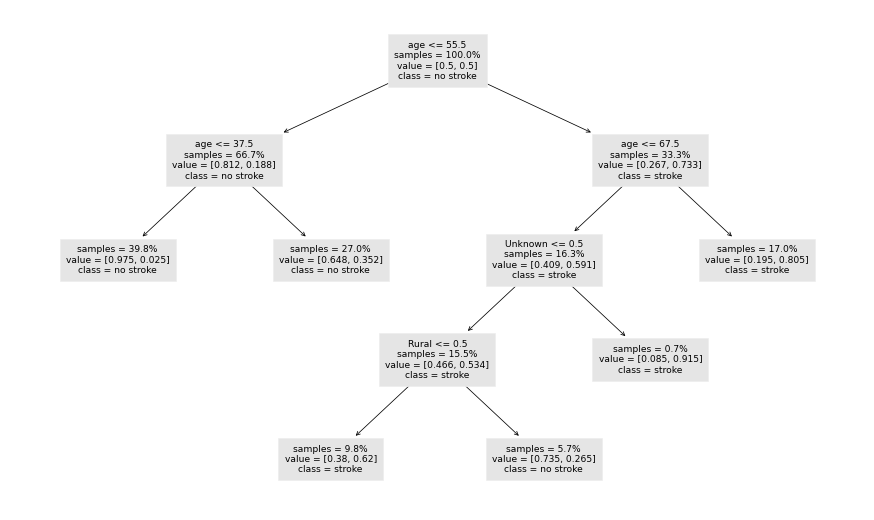

In [31]:
model = make_clas(DecisionTreeClassifier(class_weight='balanced', ccp_alpha=0.006), onehot=True, scale=False, smote=False)
result = cv_model(model, X_tr, y_tr)
report3 = cv_report(result, 'Decision Tree')
test3 = test_model(model, 'Decision Tree')

plt.figure()
plot_tree(model['classifier'], fontsize=6, impurity=False, proportion=True, feature_names=names, class_names=['no stroke', 'stroke'])
plt.show()

In [32]:
model = make_clas(DecisionTreeClassifier(class_weight='balanced', ccp_alpha=0.006), onehot=True, scale=False, smote=True)
result = cv_model(model, X_tr, y_tr)
report3a = cv_report(result, 'Decision Tree')

              mean       std
roc_auc   0.627679  0.076915
g_mean    0.531942  0.139372
accuracy  0.896364  0.033895


# Porównanie klasyfikatorów

**Wnioski z walidacji krzyżowej**

- Algorytmy uzyskują podobne wartości miar.
- Drzewo decyzyjne ma największe odchylenie standardowe w dokładności, prawdobodobnie przez to, że nie używa SMOTE.
- Regresja logistyczna ma wysze ROC AUC i gmean od naiwnego Bayesa i drzewa decyzyjnego. Ma marginalnie mniejsze accuracy od naiwnego Bayesa.
- Drzewo decyzyjne osiąga najniższe wartości miar.
- Różnice wartości miar pomiędzy modelami są małe i pewnie nieistotne.

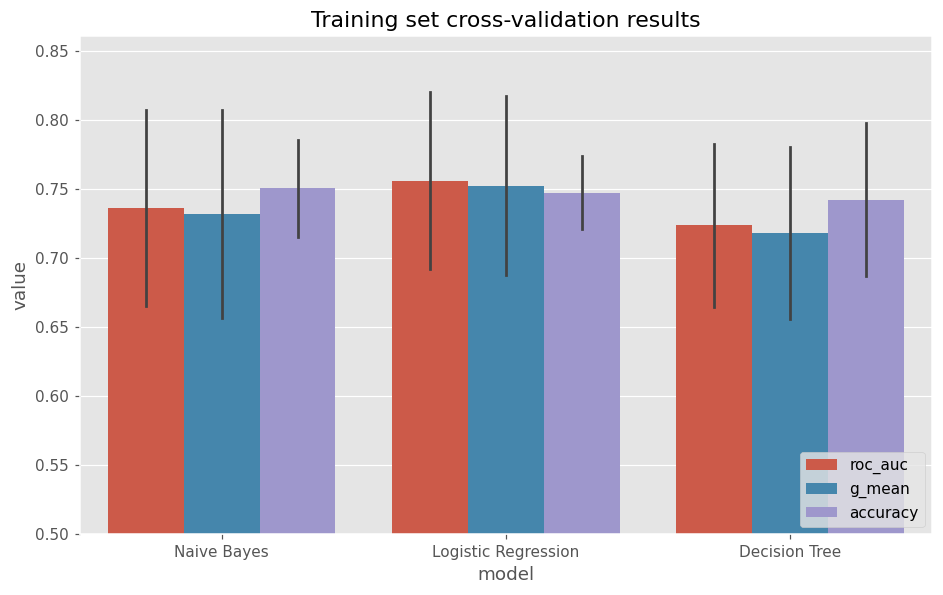

In [33]:
report = pd.concat([report1, report2, report3])
report = pd.melt(report, id_vars='model', value_vars=metrics, var_name='metric')
sns.barplot(x='model', y='value', hue='metric', ci='sd', estimator=np.mean, data=report)
plt.title('Training set cross-validation results')
plt.legend(loc='lower right')
plt.ylim(0.5)
plt.show()

**Wnioski na zbiorze testowym**

- Wszystkie algorytmy podobnie generalizują.
- Regresja logistyczna osiąga wyższe niż reszta ROC AUC (ok 2%) na zbiorze testowym.
- Drzewo decyzyjne osiąga wyższe niż reszta accuracy (ok 2%).
- Naive Bayes ma ok 2% niższe g-mean niż reszta.
- Różnice wartości miar w walidacji krzyżowej faktycznie nie przełożyły się na znaczące różnice na zbiorze testowym

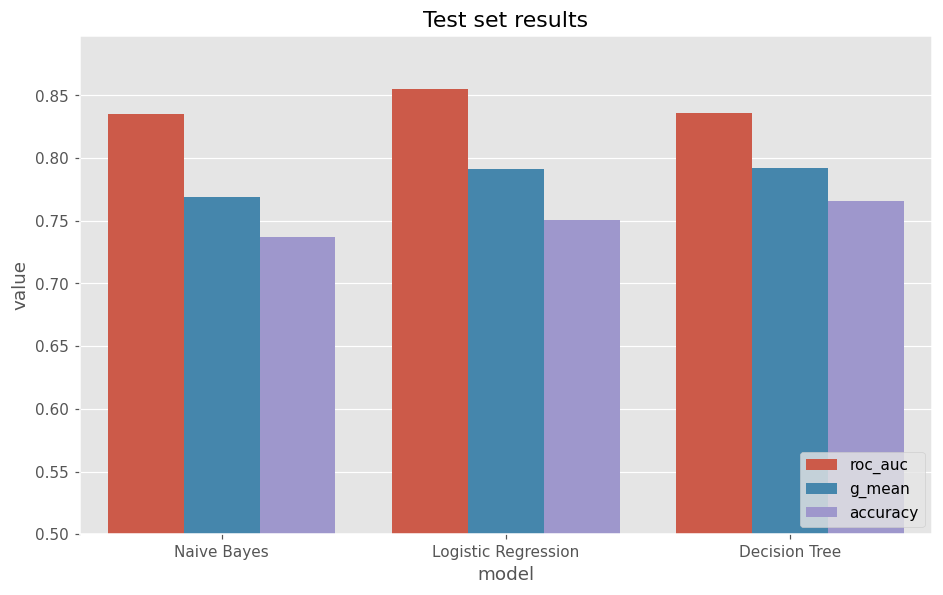

In [34]:
report = pd.DataFrame([test1, test2, test3])
report = pd.melt(report, id_vars='model', value_vars=metrics, var_name='metric')
sns.barplot(x='model', y='value', hue='metric', data=report)
plt.title('Test set results')
plt.legend(loc='lower right')
plt.ylim(0.5)
plt.show()